# Data Science | Lab: Natural Language Processing
**Table of Contents:**  <a name="toc"></a>
1. [Accessing Websites](#crwaling)
2. [Vectorizing Text](#vect)
3. [Document Classification](#classification)

## Accessing Websites <a name="crawling"></a>

For this lab, we will rely on[requests](https://docs.python-requests.org/en/latest/) and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to help us access text data from weg pages.
The following is a short glossary explaining some common terms used when collecting data:
- **Crawler** Finding and downloading web pages automatically is called crawling. A program that
downloads pages is called a web crawler.
- **Parser** Interpreting and reconstructing the structure of a website is called parsing.
- **Scraper** Extracting the content of a website (text only) is called scraping.

In addition, [boilerpipe](https://pypi.org/project/boilerpy3/) can be used to automatically remove the boilerplate.

<div class="alert alert-block alert-info">
    <b>Politeness</b></br>
    Be polite when crawling web pages! Do not fetch more than one page at a time from a particular web server. Wait in between requests. Respect the <tt>robots.txt</tt> file if provided.
</div>

[Back to top](#toc)

In [156]:
import requests  # crawling
from bs4 import BeautifulSoup  # parsing, scraping
import pandas as pd
import os
import time
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

# importing NearestCentoird from sklearn
from sklearn.neighbors import NearestCentroid

# import confusion matrix
from sklearn.metrics import confusion_matrix

# import KNN from sklearn
from sklearn.neighbors import KNeighborsClassifier

# importing train_test_split
from sklearn.model_selection import train_test_split

# GridSearch imports
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import f1_score
from sklearn.metrics import f1_score

### Constructing the News Article Dataset
The following code is used to read and store all links and headers of articles categorized under the topics *artificial intelligence* and *neuroscience* from [Wired UK](https://www.wired.co.uk).

``build_dataset()`` takes a ``seed_url`` (topic overview page) as its sole argument and stores an article's header, its link and associated topic in a dataframe.

In [2]:
def build_dataset(seed_url):
    articles = {
        'topic': [],
        'link': [],
        'header': [],
    }
    data = requests.get(seed_url)
    time.sleep(1) # sleeping for 1 second to make sure we are polite!
    soup = BeautifulSoup(
        data.content.decode('utf-8', 'ignore'),
        'html.parser',
    )
    candidates = soup.find_all(
        "a",
        class_=[
            "summary-item-tracking__hed-link",
            "summary-item__hed-link",
        ],
    )
    for article in candidates:
        articles['topic'].append(seed_url.split('/')[-1])
        articles['link'].append(article['href'])
        articles['header'].append(article.get_text().strip())

    return pd.DataFrame(articles)

<div class="alert alert-block alert-info">
    <b>Caution:</b> Instead of crawling the webpage multiple times, use locally stored data!
</div>

In [3]:
seed_url = 'https://www.wired.co.uk/topic/'
# We only want to crawl the web if absolutely necessary, so we check first if we already have an article_headers.csv in our directory
if os.path.exists('article_headers.csv'):
    df = pd.read_csv(
        'article_headers.csv',
        sep='\t',
    )
    print('read articles from file')
else:
    print('crawling articles from web...')
    # Crawl and parse the AI page
    df = build_dataset(seed_url + 'artificial-intelligence')

    # Crawl and parse the neuroscience page
    df_ns = build_dataset(seed_url + 'neuroscience')

    df = pd.concat(
        [
            df,
            df_ns
        ],
        ignore_index=True,
    )
    df.to_csv(
        'article_headers.csv',
        sep='\t',
        index=False,
    )

read articles from file


In [4]:
display(df.head())
display(df.tail())

,topic,link,header
0,artificial-intelligence,/story/why-beating-china-in-ai-brings-its-own-...,Why ‘Beating China’ in AI Brings Its Own Risks
1,artificial-intelligence,/story/botto-the-millionaire-ai-artist-is-gett...,"Botto, the Millionaire AI Artist, Is Getting a..."
2,artificial-intelligence,/story/onlyfans-models-are-using-ai-impersonat...,OnlyFans Models Are Using AI Impersonators to ...
3,artificial-intelligence,/story/celsius-founder-alex-mashinsky-pleads-g...,Celsius Founder Alex Mashinsky Pleads Guilty t...
4,artificial-intelligence,/story/robot-army-proxie-humanoid/,The Man Behind Amazon’s Robot Army Wants Every...


,topic,link,header
43,neuroscience,/story/cognito-wearable-device-light-sound-tre...,A New Headset Aims to Treat Alzheimer’s With L...
44,neuroscience,https://www.wired.com/review/vasco-translator-...,Vasco's Translator E1 Brings Impressive Real-T...
45,neuroscience,https://www.wired.com/gallery/best-wireless-he...,We Spent Thousands of Hours Listening to Find ...
46,neuroscience,https://www.wired.com/gallery/best-indoor-air-...,The Best Air Quality Monitors We’ve Tried
47,neuroscience,https://www.wired.com/gallery/posture-correcto...,The Best Posture Correctors to Straighten You Up


[Back to top](#toc)

## Vectorizing Text <a name="vect"></a>
Now, it's time to preprocess and vectorize the data and create the Bag-of-Words (BoW) vectors for each document. Before building a larger dataset, we will work with the **article headers as documents**.

### The ``CountVectorizer``
With the ``CountVectorizer``, scikit-learn offers an all-in-one solution for the preprocessing and vectorization of text data. Read through the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and make yourself familiar with its usage. Make sure to understand
* how tokenization is applied
* how to remove low and high frequency words or stopwords
* how to reduce vocabulary size by applying lowercasing
* how to build a binary incidence matrix vs. a frequency matrix

Vectorize the text by adding/changing the parameters when initializing the ``CountVectorizer`` in the following code cell. Make sure to
* tokenize
* lowercase
* remove tokens that occur in less than two documents

In [5]:
train_data = df['header']

vectorizer = CountVectorizer(
    stop_words='english',
)
X_train = vectorizer.fit_transform(train_data)

print(X_train.shape)

(48, 216)


``vectorizer`` now holds the bag-of-words vector for each document. Analyze the object further by inspecting the following properties and methods:
* ``vocabulary_`` 
* ``stop_words_``
* ``get_feature_names_out()``

In [6]:
#print(vectorizer.vocabulary_)
#print(vectorizer.get_stop_words())  # all terms that are discarded by the vectorizer (e.g. defined as stopwords, frequency too low/high, ...)
#print(vectorizer.get_feature_names_out())

Afterwards, make sure to understand the difference between the following outputs:

In [108]:
#print(X_train)
#print(X_train.todense())

[Back to top](#toc)

### The Document-Term Matrix
Given this starter example of only article headers resulting in low-dimensional BoW vectors, it is possible to plot the resulting document-term-matrix as follows:

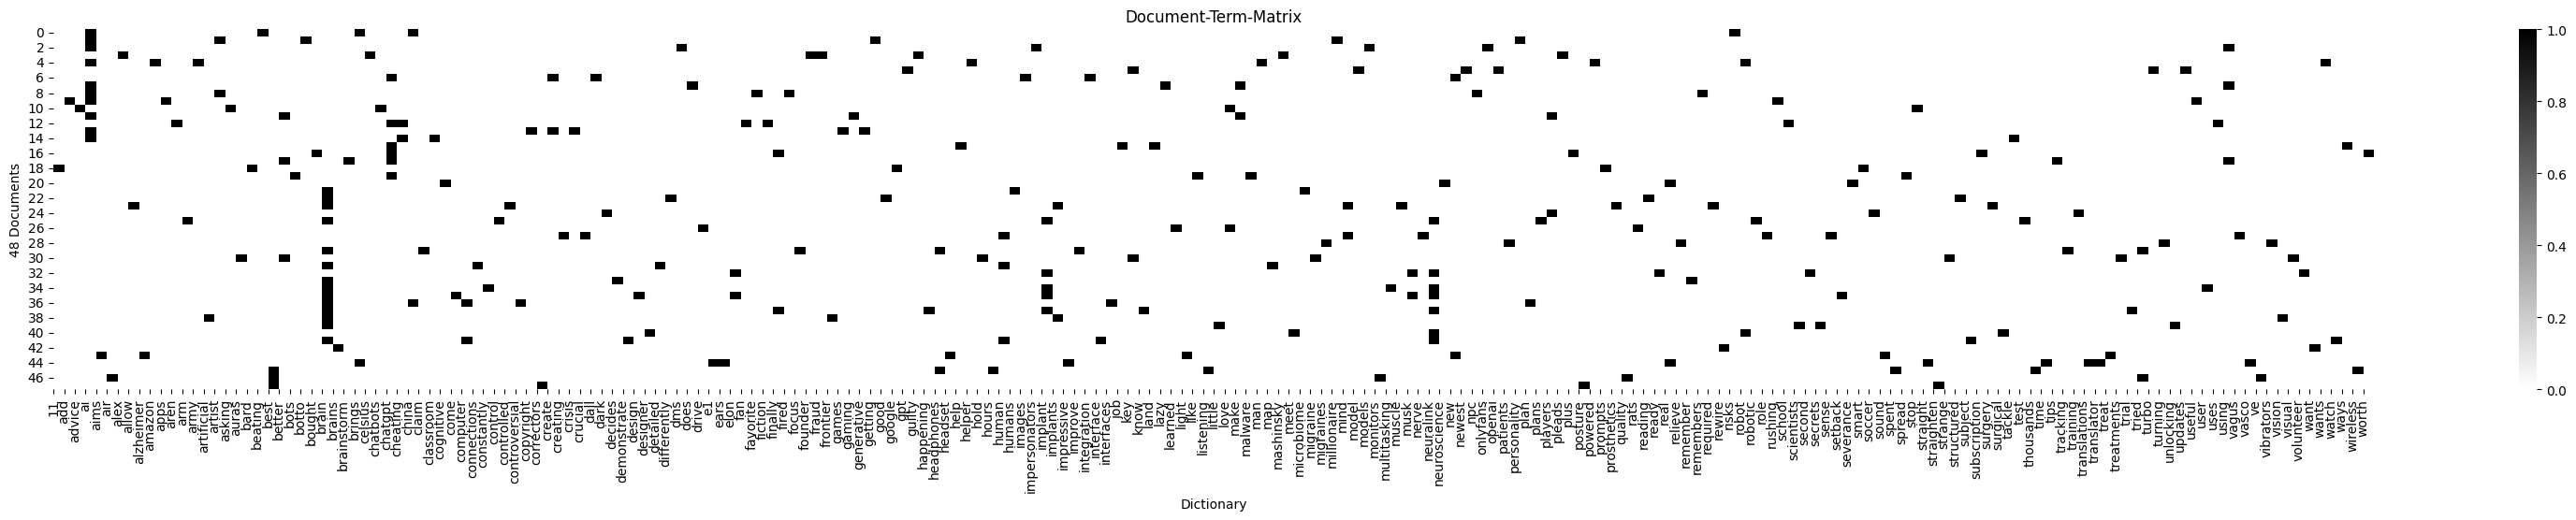

In [8]:
fig, ax = plt.subplots(figsize=(40, 5))
sns.heatmap(
    X_train.todense(),
    ax=ax,
    cmap='gray_r',
)
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(vectorizer.get_feature_names_out(), rotation=90)
ax.set_xlabel('Dictionary')
ax.set_ylabel(f'{X_train.shape[0]} Documents')
ax.set_title('Document-Term-Matrix')
plt.show()

You can also fit a ``TfidfVectorizer`` to see how the BoW vectors change.

## Document Classification <a name="classification"></a>

<img src="https://www.nltk.org/images/supervised-classification.png" style="width: 400px;"/>

[Back to top](#toc)

Now, train a document classifier on the article texts to predict the article category (topic). 

- Use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to extract the features of the article headers.
- Use the MinDist classifier to predict the topics. Remember that in scikit-learn, the classifier is called [Nearest Centroid](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html?highlight=nearest%20centroid#sklearn.neighbors.NearestCentroid) classifier. Experiment with cosine distance instead of Euclidean distance.
<div class="alert alert-block alert-warning">
        <strong>Please note:</strong> While cosine distance is an intuitive similarity measure in high dimensional data spaces, its usage as a distance metric for <tt>NearestCentroid</tt> was deprecated in scikit-learn version 1.3 and removed in version 1.5.<br>You can decide for yourself if you'd like to downgrade your scikit-learn version to be able to use cosine distance or use other distance metrics (e.g. Manhattan distance) in your experiments.
    </div>
- In order to assess the classifier's performance, use the test dataset provided as ``test_articles.csv`` on Moodle and plot the confusion matrix.

### Training data

In [9]:
def train_classifier(traning_data: pd.DataFrame, labels: pd.DataFrame, metric: str):
    classifier = NearestCentroid(metric=metric)
    classifier.fit(traning_data, labels)
    return classifier

def train_with_KNN(traning_data: pd.DataFrame, labels: pd.DataFrame, metric: str):
    classifier = KNeighborsClassifier(metric=metric)
    classifier.fit(traning_data, labels)
    return classifier

### Read test_articles and test it

In [10]:
def test_new_data(classifier, test_data_file: str):
    df_test = pd.read_csv(test_data_file, sep=';')

    test_headers = df_test['header']
    test_labels = df_test['topic']

    x_test = vectorizer.transform(test_headers)

    # predict the labels of the test data
    predicted_labels = classifier.predict(x_test)

    # check the accuracy of the model
    accuracy = (predicted_labels == test_labels)

    df_test['predicted_topic'] = predicted_labels
    df_test['is_correct'] = None
    df_test['is_correct'] = df_test['predicted_topic'] == df_test['topic']

    return df_test, accuracy

def display_classifier_info(df_test: pd.DataFrame, accuracy: float):
    display(df_test.head())
    print(f'Accuracy: {accuracy.mean()}')

def plot_confusion_matrix(result_dataframe: pd.DataFrame, ax: plt.Axes, metric: str):
    cm = confusion_matrix(result_dataframe['topic'], result_dataframe['predicted_topic'])
    if ax is None:
        fig, ax = plt.subplots()
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=ax,
        linewidths=1,
        linecolor='black',
    )
    ax.set_xlabel('Predicted topic')
    ax.set_ylabel('True topic')
    ax.set_title(f'Confusion Matrix with metric : {metric}')
    return ax

Training classifier with metric: euclidean


,topic,link,header,article,predicted_topic,is_correct
0,artificial-intelligence,/article/game-of-thrones-season-8-predictions,Who will die in Game of Thrones season 8? Scie...,Daenerys has a one per cent chance of death; A...,neuroscience,False
1,artificial-intelligence,/article/artificial-intelligence-extended-inte...,"Forget about artificial intelligence, extended...",We should challenge the cult of Singularity. A...,neuroscience,False
2,artificial-intelligence,/article/marcus-du-sautoy-book-extract-creativ...,What's the purpose of humanity if machines can...,Flashes of inspiration are considered a human ...,neuroscience,False
3,artificial-intelligence,/article/avoid-facial-recognition-software,How to hack your face to dodge the rise of fac...,"Use of facial recognition tech is on the rise,...",neuroscience,False
4,artificial-intelligence,/article/deepmind-ai-chess,DeepMind’s superhuman AI is rewriting how we p...,AlphaZero doesn’t play chess like a machine – ...,artificial-intelligence,True


Accuracy: 0.4
------------------------------

Training classifier with metric: manhattan


,topic,link,header,article,predicted_topic,is_correct
0,artificial-intelligence,/article/game-of-thrones-season-8-predictions,Who will die in Game of Thrones season 8? Scie...,Daenerys has a one per cent chance of death; A...,artificial-intelligence,True
1,artificial-intelligence,/article/artificial-intelligence-extended-inte...,"Forget about artificial intelligence, extended...",We should challenge the cult of Singularity. A...,artificial-intelligence,True
2,artificial-intelligence,/article/marcus-du-sautoy-book-extract-creativ...,What's the purpose of humanity if machines can...,Flashes of inspiration are considered a human ...,artificial-intelligence,True
3,artificial-intelligence,/article/avoid-facial-recognition-software,How to hack your face to dodge the rise of fac...,"Use of facial recognition tech is on the rise,...",artificial-intelligence,True
4,artificial-intelligence,/article/deepmind-ai-chess,DeepMind’s superhuman AI is rewriting how we p...,AlphaZero doesn’t play chess like a machine – ...,artificial-intelligence,True


Accuracy: 0.7
------------------------------



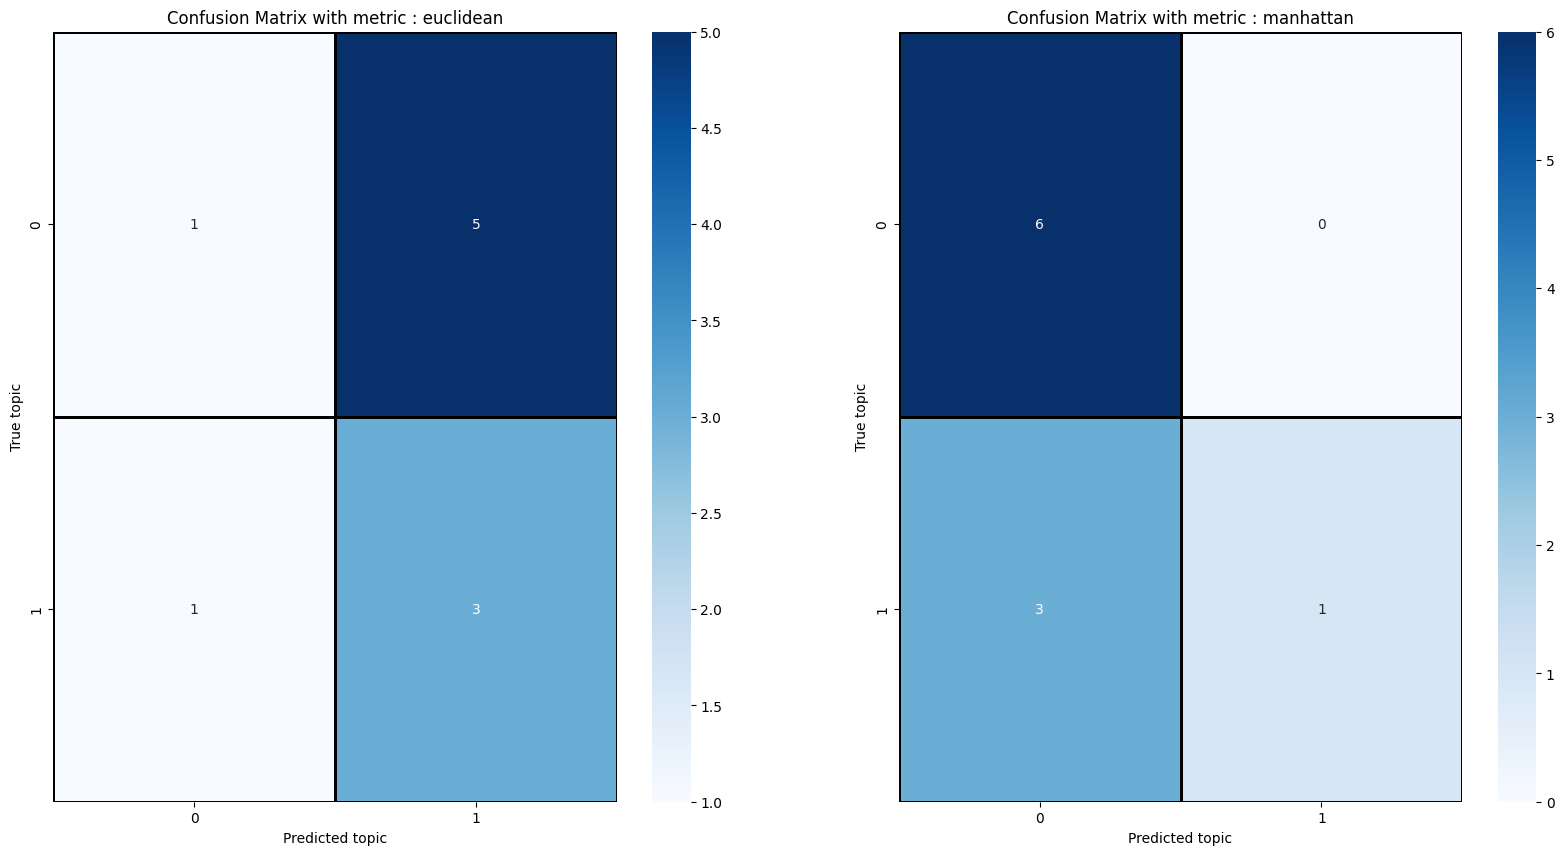

In [11]:
metrics = ['euclidean', 'manhattan']

figure, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()

for index, metric in enumerate(metrics):
    print(f'Training classifier with metric: {metric}')
    classifier = train_classifier(X_train, df['topic'], metric)
    df_test, accuracy = test_new_data(classifier, 'test_articles.csv')
    display_classifier_info(df_test, accuracy)
    plot_confusion_matrix(df_test, axes[index], metric)

    print('---' * 10)
    print()

plt.show()

Training classifier with metric: euclidean


,topic,link,header,article,predicted_topic,is_correct
0,artificial-intelligence,/article/game-of-thrones-season-8-predictions,Who will die in Game of Thrones season 8? Scie...,Daenerys has a one per cent chance of death; A...,neuroscience,False
1,artificial-intelligence,/article/artificial-intelligence-extended-inte...,"Forget about artificial intelligence, extended...",We should challenge the cult of Singularity. A...,neuroscience,False
2,artificial-intelligence,/article/marcus-du-sautoy-book-extract-creativ...,What's the purpose of humanity if machines can...,Flashes of inspiration are considered a human ...,neuroscience,False
3,artificial-intelligence,/article/avoid-facial-recognition-software,How to hack your face to dodge the rise of fac...,"Use of facial recognition tech is on the rise,...",neuroscience,False
4,artificial-intelligence,/article/deepmind-ai-chess,DeepMind’s superhuman AI is rewriting how we p...,AlphaZero doesn’t play chess like a machine – ...,artificial-intelligence,True


Accuracy: 0.6
------------------------------

Training classifier with metric: manhattan


,topic,link,header,article,predicted_topic,is_correct
0,artificial-intelligence,/article/game-of-thrones-season-8-predictions,Who will die in Game of Thrones season 8? Scie...,Daenerys has a one per cent chance of death; A...,neuroscience,False
1,artificial-intelligence,/article/artificial-intelligence-extended-inte...,"Forget about artificial intelligence, extended...",We should challenge the cult of Singularity. A...,neuroscience,False
2,artificial-intelligence,/article/marcus-du-sautoy-book-extract-creativ...,What's the purpose of humanity if machines can...,Flashes of inspiration are considered a human ...,neuroscience,False
3,artificial-intelligence,/article/avoid-facial-recognition-software,How to hack your face to dodge the rise of fac...,"Use of facial recognition tech is on the rise,...",neuroscience,False
4,artificial-intelligence,/article/deepmind-ai-chess,DeepMind’s superhuman AI is rewriting how we p...,AlphaZero doesn’t play chess like a machine – ...,artificial-intelligence,True


Accuracy: 0.6
------------------------------

Training classifier with metric: cosine


,topic,link,header,article,predicted_topic,is_correct
0,artificial-intelligence,/article/game-of-thrones-season-8-predictions,Who will die in Game of Thrones season 8? Scie...,Daenerys has a one per cent chance of death; A...,neuroscience,False
1,artificial-intelligence,/article/artificial-intelligence-extended-inte...,"Forget about artificial intelligence, extended...",We should challenge the cult of Singularity. A...,neuroscience,False
2,artificial-intelligence,/article/marcus-du-sautoy-book-extract-creativ...,What's the purpose of humanity if machines can...,Flashes of inspiration are considered a human ...,neuroscience,False
3,artificial-intelligence,/article/avoid-facial-recognition-software,How to hack your face to dodge the rise of fac...,"Use of facial recognition tech is on the rise,...",neuroscience,False
4,artificial-intelligence,/article/deepmind-ai-chess,DeepMind’s superhuman AI is rewriting how we p...,AlphaZero doesn’t play chess like a machine – ...,artificial-intelligence,True


Accuracy: 0.5
------------------------------



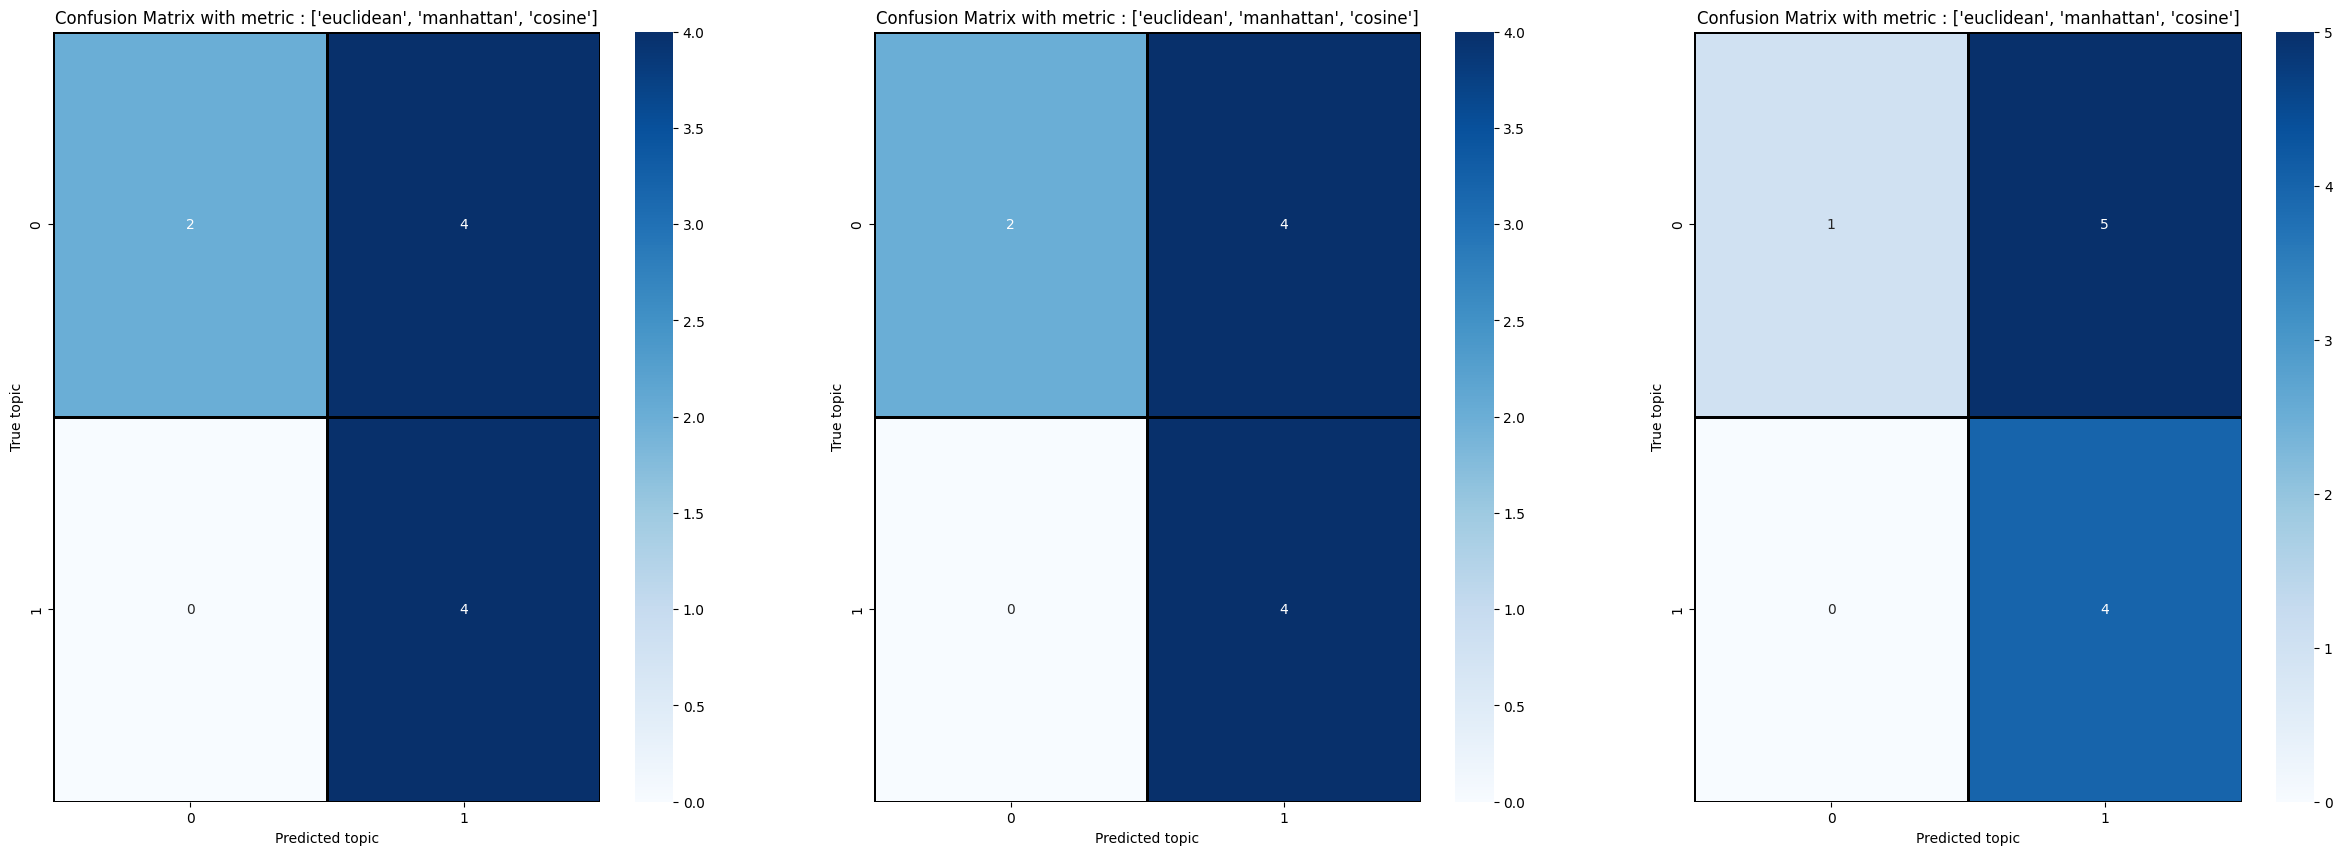

In [12]:
knn_metrics = ['euclidean', 'manhattan', 'cosine']

figure, axes = plt.subplots(1, 3, figsize=(30, 10))
axes = axes.flatten()

for index, metric in enumerate(knn_metrics):
    print(f'Training classifier with metric: {metric}')
    classifier = train_with_KNN(X_train, df['topic'], metric)
    df_test, accuracy = test_new_data(classifier, 'test_articles.csv')
    display_classifier_info(df_test, accuracy)
    plot_confusion_matrix(df_test, axes[index], knn_metrics)

    print('---' * 10)
    print()

plt.show()

## Homework Assignment

Extend your code to include the following:
1. Add a third topic of your choice to the link list DataFrame. 
2. Access the website of each link in your list and extract the article text. Store it in a new columns in your DataFrame. (Make sure to be polite! Add ``time.sleep(...)`` before accessing the next page.)
3. Set aside a small percentage of the dataset you created (~ten percent) to be used for testing later on.
4. Set up a grid search for at least three different parameters of the vectorizer.
5. Evaluate the grid with 5-fold cross validation to find the best hyperparameters for vectorizer and classifier concerning <b>F1 score</b> when trained on the full article texts.
6. Plot the confusion matrix for the test dataset you created in Step 3.


## Moodle Upload
Upload your notebook as ``firstname_lastname_nlp.html`` to Moodle. Make sure to consider the following:
* Have all your import statements in one single cell at the top of the notebook.
* Remove unnecessary code (such as plotting the document-term-matrix, experimenting with the properties and methods of the CountVectorizer, ...)
* Print the head of your final DataFrame (containing article texts) once.
* Include a markdown cell at the end where you:
    * give a short overview of what your notebook is about
    * describe and interpret your grid settings and justify your choices
    * analyze the final/best results

# HOMEWORK

In [101]:
# Code snippets that works for techcrunch
def build_dataset(seed_url):
    articles = {
        'topic': [],
        'link': [],
        'header': [],
        'text': [],
    }
    data = requests.get(seed_url)
    time.sleep(1) # sleeping for 1 second to make sure we are polite!
    soup = BeautifulSoup(
        data.content.decode('utf-8', 'ignore'),
        'html.parser',
    )
    candidates = soup.find_all(
        "a",
        class_=[
            "loop-card__title-link",
        ],
    )
    for article in candidates:
        articles['topic'].append(seed_url.split('/')[-1])
        articles['link'].append(article['href'])
        articles['header'].append(article.get_text().strip())
        articles['text'].append("")

    return pd.DataFrame(articles)

In [102]:
selected_topics = ['artificial-intelligence', 'security', 'media-entertainment']
dfs = []

seed_url = 'https://techcrunch.com/category/'
# We only want to crawl the web if absolutely necessary, so we check first if we already have an article_headers.csv in our directory
if os.path.exists('article_headers_tech_crunch.csv'):
    df = pd.read_csv(
        'article_headers_tech_crunch.csv',
        sep='\t',
    )
    print('read articles from file')
else:
    print('crawling articles from web...')
    # Crawl and parse the AI page
    for index, topic in enumerate(selected_topics):
        df = build_dataset(seed_url + topic)
        dfs.append(df)

    df = pd.concat(
        dfs,
        ignore_index=True,
    )

    df.to_csv(
        'article_headers_tech_crunch.csv',
        sep='\t',
        index=False,
    )

read articles from file


### Retriving Text from the links

In [110]:
for index, seed_url in enumerate(df['link']):
    data = requests.get(seed_url)
    time.sleep(1)
    soup = BeautifulSoup(
        data.content.decode('utf-8', 'ignore'),
        'html.parser',
    )

    content = soup.find(
        "div",
        class_=["entry-content"],
    )
    if content: # Check if content exists

        paragraphs = content.find_all('p', class_ = ["wp-block-paragraph"])
        article_text = "".join([p.get_text().strip() for p in paragraphs])
    else:
        article_text = ""

    df.loc[index, 'text'] = article_text



### Check if text was retrived succesfully

In [39]:
display(df.head())
display(df.tail())

,topic,link,header,text
0,artificial-intelligence,https://techcrunch.com/2025/02/04/softbank-bac...,SoftBank-backed billionaire to invest $230M in...,Ola founder Bhavish Aggarwal is investing $230...
1,artificial-intelligence,https://techcrunch.com/2025/02/04/google-and-d...,"AI agents for e-commerce startup, founded by G...","AI is changing how we shop online, making our ..."
2,artificial-intelligence,https://techcrunch.com/2025/02/03/neuralk-ai-i...,Neuralk-AI is developing AI models specificall...,Tabular data is a broad term that encompasses ...
3,artificial-intelligence,https://techcrunch.com/2025/02/03/accel-backs-...,Accel backs Indian AI startup building ‘ChatGP...,"Presentations.ai, an Indian startup that uses ..."
4,artificial-intelligence,https://techcrunch.com/2025/02/03/naver-backed...,Naver-backed Cinamon wants to make 3D video an...,It’s never been easier to create and publish a...


,topic,link,header,text
106,media-entertainment,https://techcrunch.com/2025/02/03/heros-all-in...,"Hero’s all-in-one, AI productivity app takes o...","People often use multiple apps for notes, sche..."
107,media-entertainment,https://techcrunch.com/2025/02/02/deepseek-fou...,DeepSeek founder Liang Wenfeng receives a hero...,DeepSeek founder Liang Wenfeng is being hailed...
108,media-entertainment,https://techcrunch.com/2025/02/02/openai-unvei...,OpenAI unveils a new ChatGPT agent for ‘deep r...,OpenAI is announcing a new AI “agent” designed...
109,media-entertainment,https://techcrunch.com/2025/02/02/dub-the-copy...,Dub: The copy trading app that has teens talking,"Social media changed everything, from news con..."
110,media-entertainment,https://techcrunch.com/2025/02/01/x-expands-la...,X expands lawsuit over advertiser ‘boycott’ to...,X is now suing more advertisers in an antitrus...


### Splitting the data in test and train sets

In [145]:
# splitting data into 90:10 ratios (as written in instructions)

train_text, test_text, train_topics, test_topics = train_test_split(
    df['text'],
    df['topic'],
    test_size=0.1,
    random_state=42,
)

### Grid Search

In [133]:
vec = CountVectorizer()


stop_words = ['english', None]
max_features = [100, 250, 500, 750, 1000]
max_df = [0.5, 0.75, 1.0]
min_df = [1, 2, 3, 5]
ngram_range = [(1, 1), (1, 2)]
binary = [True, False]

metrics = ['euclidean', 'manhattan', 'cosine']

for metric in metrics:

    classifier = KNeighborsClassifier(n_neighbors=5, metric=metric)
    pipe = Pipeline([
        ('vec', vec),
        ('classifier', classifier)])

    param_grid = {
        'vec__stop_words': stop_words,
        'vec__max_features': max_features,
        'vec__max_df': max_df,
        'vec__min_df': min_df,
        'vec__ngram_range': ngram_range,
        'vec__binary': binary}

    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='f1_weighted',
        verbose=1,
    )

    grid_search.fit(train_text, train_topics)

    print(f"Best parameters ({metric}) :  {grid_search.best_params_}")
    print(f"Best F1 score ({metric}) :  {grid_search.best_score_}")

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best parameters (euclidean) :  {'vec__binary': False, 'vec__max_df': 0.75, 'vec__max_features': 100, 'vec__min_df': 2, 'vec__ngram_range': (1, 2), 'vec__stop_words': None}
Best F1 score (euclidean) :  0.6310892966682441
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best parameters (manhattan) :  {'vec__binary': True, 'vec__max_df': 0.75, 'vec__max_features': 250, 'vec__min_df': 3, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}
Best F1 score (manhattan) :  0.593758311863575
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best parameters (cosine) :  {'vec__binary': False, 'vec__max_df': 1.0, 'vec__max_features': 100, 'vec__min_df': 2, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}
Best F1 score (cosine) :  0.7364119477014214


### Testing Best Parameters

Accuracy for grid search with metric euclidean: 0.83%
F1 score for grid search with metric euclidean: 0.83

Accuracy for grid search with metric manhattan: 0.58%
F1 score for grid search with metric manhattan: 0.58

Accuracy for grid search with metric cosine: 0.67%
F1 score for grid search with metric cosine: 0.65



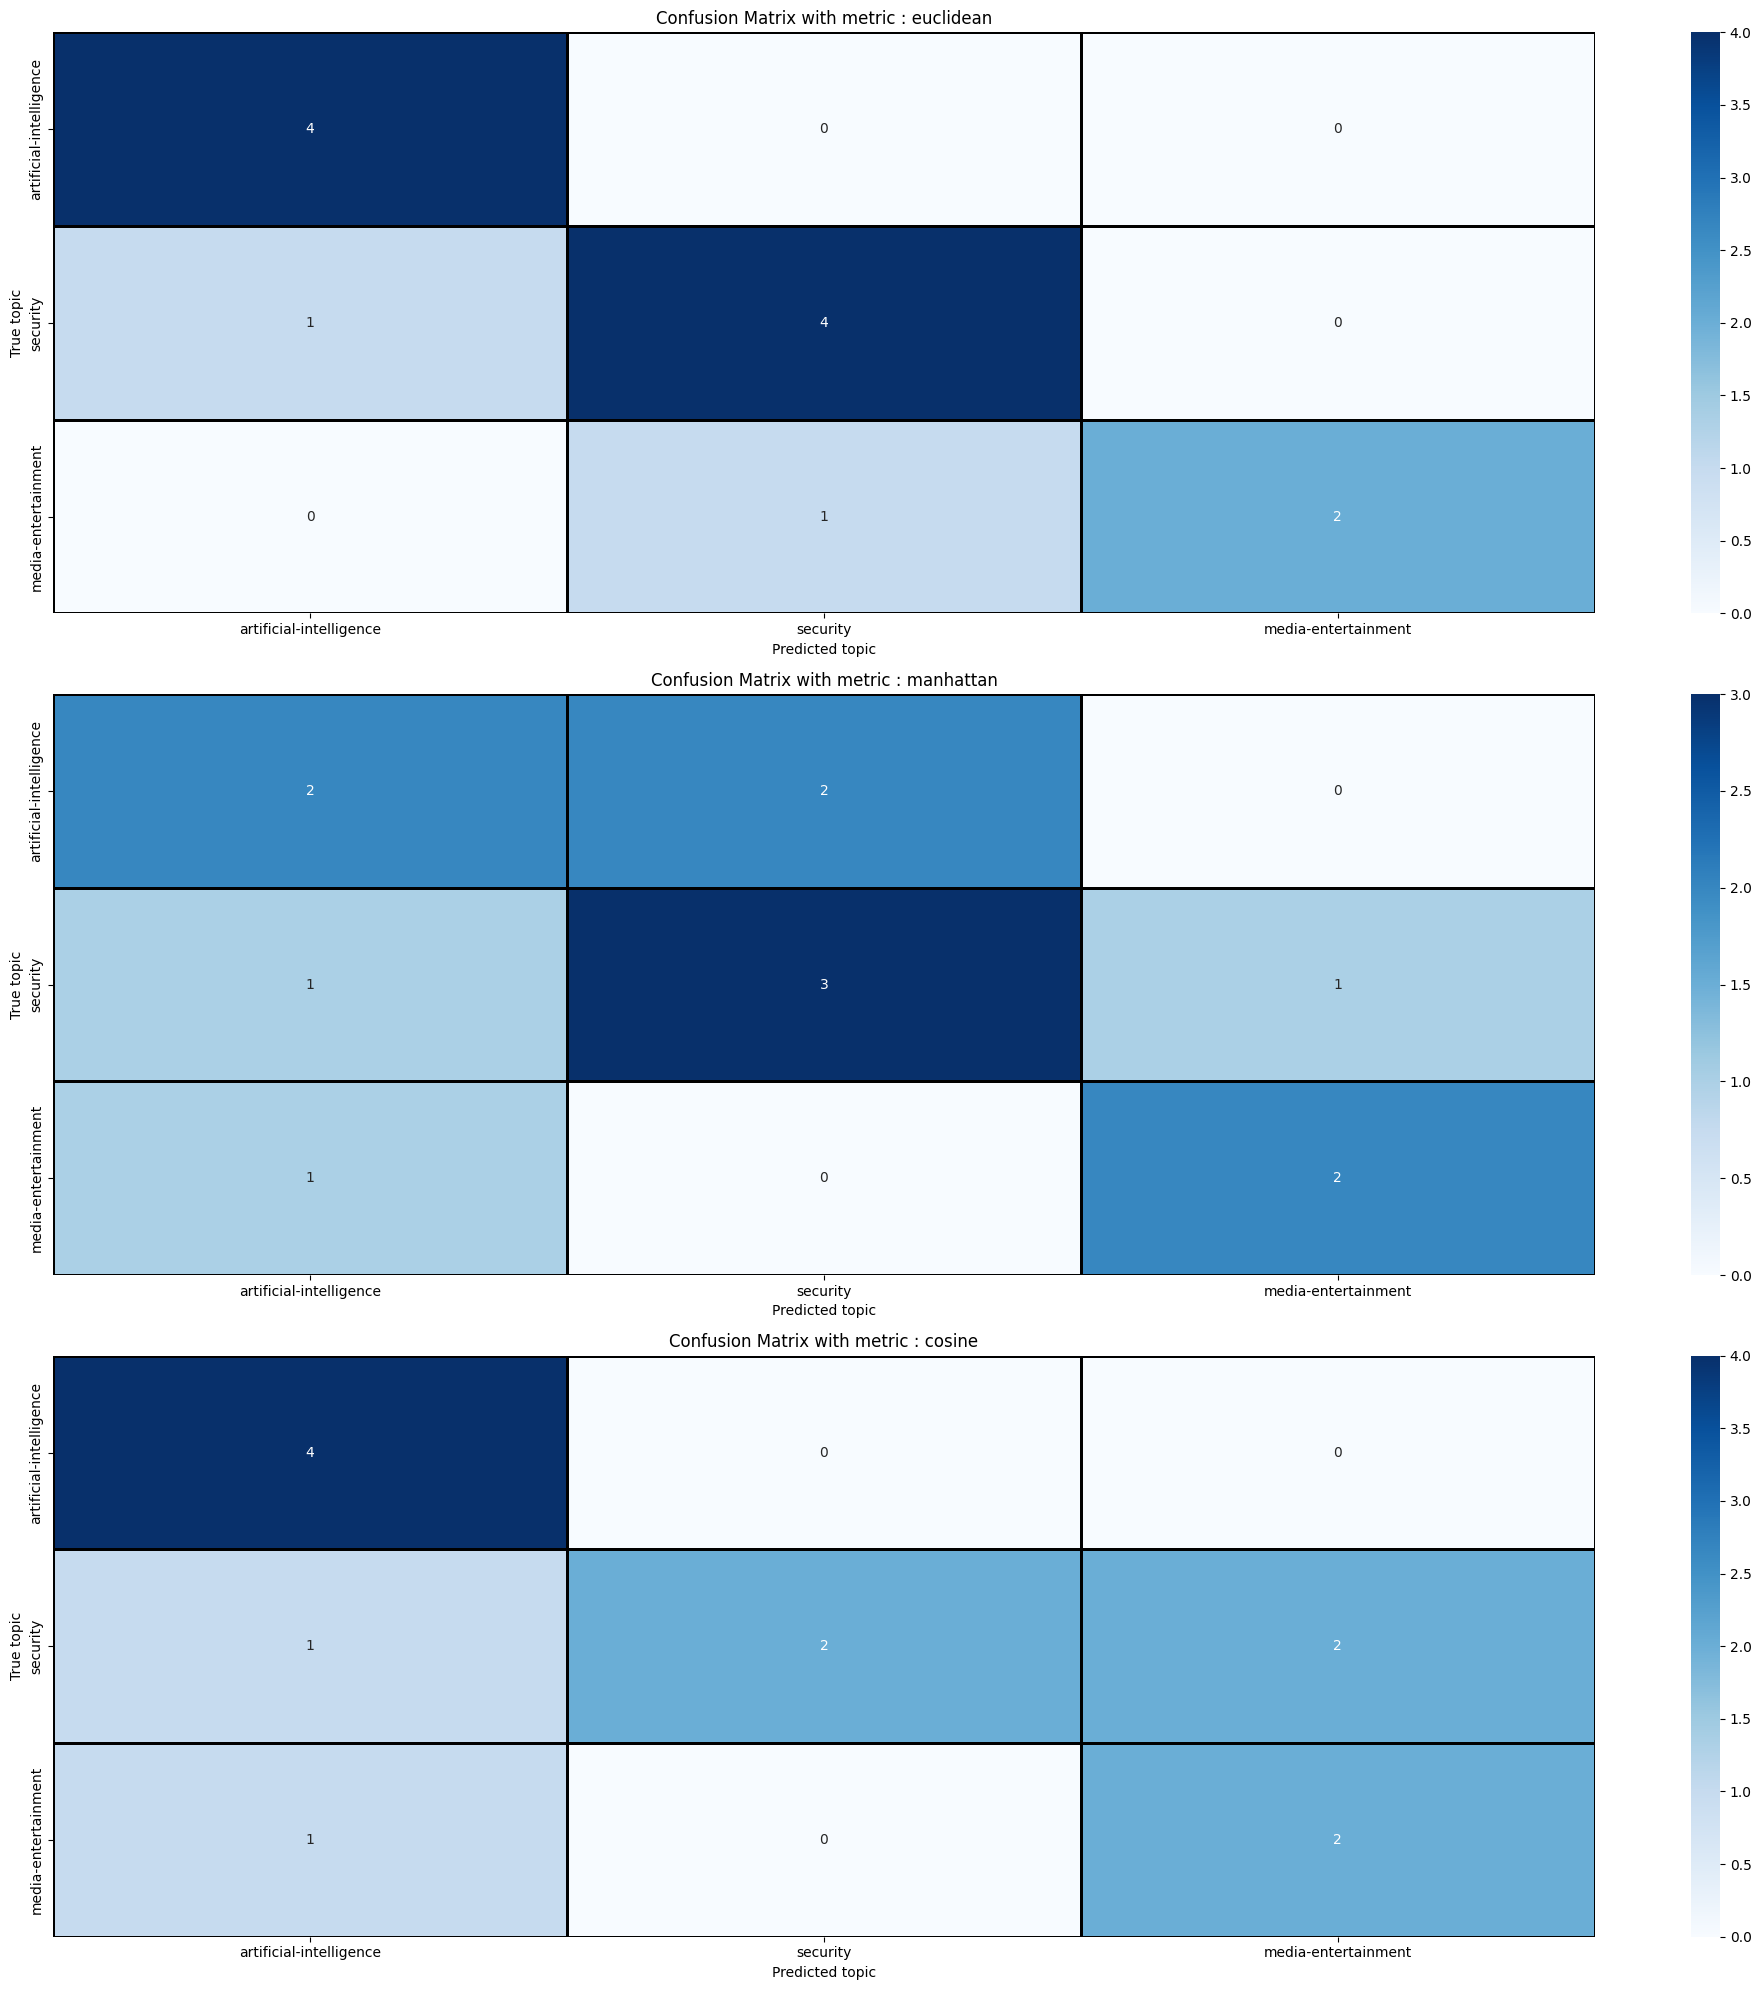

In [159]:
best_params_list = [
    {
        'max_df': 0.75,
        'max_features': 100,
        'min_df': 2,
        'stop_words': None,
        'metric': 'euclidean',
        'ngram_range': (1, 2),
        'binary': False
    },
    {
        'max_df': 0.75,
        'max_features': 250,
        'min_df': 3,
        'stop_words': "english",
        'metric': 'manhattan',
        'ngram_range': (1, 2),
        'binary': True
    },
    {
        'max_df': 1.0,
        'max_features': 100,
        'min_df': 2,
        'stop_words': "english",
        'metric': 'cosine',
        'ngram_range': (1, 2),
        'binary': False
    }
]

fig, axes = plt.subplots(3, 1, figsize=(20, 20))
axes = axes.flatten()

for i, params in enumerate(best_params_list):
    best_vec = CountVectorizer(
        stop_words=params['stop_words'],
        max_features=params['max_features'],
        max_df=params['max_df'],
        min_df=params['min_df'],
        ngram_range=params['ngram_range'],
        binary=params['binary']
    )

    classifier = KNeighborsClassifier(n_neighbors=5, metric=params['metric'])

    X_train = best_vec.fit_transform(train_text)
    classifier.fit(X_train, train_topics)

    X_test = best_vec.transform(test_text)

    predicted_topics = classifier.predict(X_test)

    score = classifier.score(X_test, test_topics)

    f1_sc = f1_score(test_topics, predicted_topics, average='weighted')

    print(f"Accuracy for grid search with metric {params['metric']}: {np.round(score, 2)}%")
    print(f"F1 score for grid search with metric {params['metric']}: {np.round(f1_sc, 2)}\n")

    cm = confusion_matrix(test_topics, predicted_topics)

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[i],
        linewidths=1,
        linecolor='black',
        xticklabels=selected_topics,
        yticklabels=selected_topics,
    )

    axes[i].set_xlabel('Predicted topic')
    axes[i].set_ylabel('True topic')
    axes[i].set_title(f'Confusion Matrix with metric : {params["metric"]}')

plt.tight_layout()
plt.show()


# Conclusions

## **Notebook Overview: Natural Language Processing & Text Classification**

This notebook focuses on Natural Language Processing (NLP), specifically analyzing how different CountVectorizer parameters and distance metrics impact the ability to correctly classify text topics.

#### **Key Steps in Our Analysis:** 
1. Data Retrieval – We extracted topics from selected categories along with their associated text.
2. Data Splitting – We divided the dataset into training and testing sets to evaluate classifier performance.
3. Classifier Selection – We used the k-Nearest Neighbors (kNN) algorithm and tested different distance metrics:
    - Euclidean Distance
    - Cosine Similarity
    - Manhattan Distance
4. Hyperparameter Tuning – We conducted a grid search to optimize CountVectorizer parameters and identify the most effective settings for text processing.
5. Performance Visualization – We generated a confusion matrix plot to visualize classification results on the test set.

#### **Additional Experiment: Testing on Article Titles**
This notebook also includes an additional laboratory task, where we evaluated our models using article titles from a different dataset to test their generalization ability.

## **GridSearch parameters choice :**

1. The **ngram_range** parameter determines the size of word sequences (n-grams) extracted from the text. Unigrams capture single words, while bigrams capture word pairs such as "machine learning" or "deep learning." This is especially important when working with AI and security-related texts, where bigram phrases frequently carry significant meaning. Unigrams are useful when individual words alone provide strong classification signals, whereas bigrams help capture important multi-word expressions. Testing different values for ngram_range allows us to find the best way to extract key terms for classification.

2. The **max_df** parameter removes words that appear in more than a specified percentage of documents. Highly frequent words such as "the," "or," and "and" often do not contribute much meaning to classification and instead add noise to the model. By filtering out these overly common words, we can improve the model’s efficiency and prevent it from learning unimportant patterns. This parameter is especially helpful in avoiding overfitting to words that appear in nearly every document.

3. The **min_df** parameter does the opposite of max_df and removes words that appear in very few documents. If a word only appears in one or two texts, it may not be relevant for general classification and could introduce noise. Rare words often include typos, uncommon names, or domain-specific terms that are not useful for topic modeling. Removing these words ensures that the vocabulary remains meaningful and that the model generalizes well without being influenced by outliers.

4. The **max_features** parameter limits the number of unique words included in the vocabulary. Instead of keeping every word that appears in the dataset, we can restrict the vocabulary to the most frequently occurring terms. This helps to keep the feature space manageable, reducing both memory usage and computation time. Selecting a smaller number of features allows the model to focus on the most relevant words while ignoring less common, potentially unimportant ones.

5. The **stop_words** parameter removes the most common English words that do not contribute meaningfully to text classification. Words like "is," "the," "and," and "was" generally appear in all types of documents and do not help in distinguishing between different topics. Eliminating stop words improves the classifier’s efficiency by focusing only on content words that provide useful information.

6. The **binary**** parameter determines whether a word’s frequency is important or whether its mere presence is sufficient. When binary=True, the model only considers whether a word appears in a document (0 or 1) rather than counting how many times it appears. This can be useful in cases where repeated occurrences of a word do not necessarily add meaning, such as when the presence of "hacking" in a document is already enough to classify it as related to cybersecurity, regardless of how many times the word appears.

By tuning these parameters, we can optimize CountVectorizer to improve the accuracy and efficiency of text classification models. The best combination of these hyperparameters depends on the dataset and the specific classification task at hand. Testing different values through grid search allows us to find the most effective settings for extracting meaningful features from text.

## **Analyzing best final results**

The confusion matrices visualize the classification performance of the k-Nearest Neighbors (kNN) classifier using three different distance metrics: Euclidean, Manhattan, and Cosine similarity. The three-class classification problem consists of the categories: artificial intelligence, security, and media entertainment.

#### **Euclidean Distance**

- Artificial intelligence (AI) articles were classified perfectly, with 4 correct predictions and 0 misclassifications.
- Security articles were mostly well classified, with 4 correct classifications and only 1 misclassification (as AI).
- Media entertainment articles had mixed results: 2 were correctly classified, but 1 was misclassified as security.

- *Conclusion:* Euclidean distance provides the best classification performance for AI and security topics, but struggles slightly with media entertainment. This suggests that media entertainment articles share some common textual features with security-related ones, making them harder to distinguish.

#### **Manhatan Distance**
- The performance on AI articles dropped compared to Euclidean distance, with 2 correctly classified and 2 misclassified as security.
- Security articles saw slightly worse performance, with 3 correct predictions, but 1 misclassified as AI and another as media entertainment.
- Media entertainment articles showed similar behavior, with 2 correctly classified, but 1 misclassified as AI.

- *Conclusion:* Manhattan distance results in more misclassifications, particularly between AI and security topics. This suggests that word frequency distributions for AI and security texts are more similar when measured using Manhattan distance, making it less effective in distinguishing them.

#### **Cosie Distance**
- AI classification remained strong, with 4 correctly classified articles.
- Security classification worsened, with only 2 correct predictions, and 2 misclassified as media entertainment.
- Media entertainment showed some improvement, with 2 correct classifications and 1 misclassified as AI.

- *Conclusion:* Cosine similarity appears to perform well for AI articles, but struggles more with security vs. media entertainment. Since cosine similarity measures the angular distance between text vectors, it suggests that security and media entertainment articles share similar keyword distributions, making them harder to separate using this approach.


## **Final Thoughs :**
- In this analysis, the best results were achieved using Euclidean Distance. Typically, Cosine Distance tends to perform better in text classification tasks, as it focuses on the direction of word frequency vectors rather than their magnitude. However, in our case, the dataset might be too small for Cosine Distance to fully demonstrate its advantages.
- It is important to note that there is no universally superior distance metric. The effectiveness of each metric depends on the specific characteristics of the dataset, such as its size, distribution of word frequencies, and topic distinctiveness. Therefore, selecting the best metric requires empirical testing to determine which one is most suitable for a given problem.
- For future improvements, I recommend experimenting with different classifiers, further fine-tuning hyperparameters, and expanding the dataset by incorporating more articles. Testing refining feature extraction methods — such as using TF-IDF instead of CountVectorizer — might enhance the model's ability to differentiate between topics more effectively.